In [ ]:
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer, save_images
from util.html import HTML
import os
from util.util import AverageMeter, set_seed, write_location

In [ ]:
import torch


opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)               # regular setup: load and print networks; create schedulers
visualizer = Visualizer(opt)  # create a visualizer that display/save images and plots
meters_tst = {stat: AverageMeter() for stat in model.loss_names}

set_seed(opt.seed)

web_dir = os.path.join(opt.results_dir, opt.name, opt.exp_id,
                        '{}_{}'.format(opt.testset_name, opt.epoch))  # define the website directory
print('creating web directory', web_dir)
webpage = HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (opt.name, opt.phase, opt.epoch))

file = open(os.path.join(opt.results_dir, opt.name, opt.exp_id, 'slot_location.txt'), 'w')

for i, data in enumerate(dataset):
    visualizer.reset()
    model.set_input(data)  # unpack data from data loader
    # model.test()           # run inference: forward + compute_visuals

    with torch.no_grad():
        model.forward()
        fg_slot_position = torch.zeros((opt.num_slots-1, 2))
        model.forground_position(fg_slot_image_position=fg_slot_position)
        model.compute_visuals()

    losses = model.get_current_losses()
    visualizer.print_test_losses(i, losses)
    for loss_name in model.loss_names:
        meters_tst[loss_name].update(float(losses[loss_name]))

    visuals = model.get_current_visuals()
    visualizer.display_current_results(visuals, epoch=None, save_result=False)
    img_path = model.get_image_paths()
    save_images(webpage, visuals, img_path, aspect_ratio=opt.aspect_ratio, width=opt.load_size)
    losses = {}
    for loss_name in model.loss_names:
        losses[loss_name] = meters_tst[loss_name].avg
    visualizer.print_test_losses('average', losses)

    break

tensor([-0.4980, -0.4039])
tensor(0)


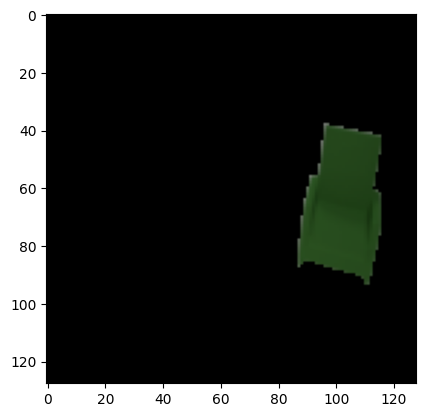

In [2]:
from cgitb import grey
import torch
import torchvision.transforms.functional as TF
import torchvision
from data.base_dataset import BaseDataset
from PIL import Image

mask_path = '/viscam/projects/uorf-extension/datasets/room_diverse_nobg/train-1obj/00000_sc0000_az00_mask.png'

def _transform_mask(img):
    img = TF.resize(img, (128, 128), Image.NEAREST)
    img = TF.to_tensor(img)
    img = TF.normalize(img, [0.5] * img.shape[0], [0.5] * img.shape[0])  # [0,1] -> [-1,1]
    return img

mask = Image.open(mask_path).convert('RGB')
mask_l = mask.convert('L')
mask = _transform_mask(mask)
mask_l = _transform_mask(mask_l)
mask_flat = mask_l.flatten(start_dim=0)  # HW,
greyscale_dict = mask_flat.unique(sorted=True)  # 8,
onehot_labels = mask_flat[:, None] == greyscale_dict  # HWx8, one-hot
onehot_labels = onehot_labels.type(torch.uint8)
mask_idx = onehot_labels.argmax(dim=1)  # HW
# bg_color is -127/255, find the index of bg_color
print(greyscale_dict)
bg_idx = torch.argmin(torch.abs(greyscale_dict - (-127/255)))
print(bg_idx)
bg_color = greyscale_dict[bg_idx]


fg_idx = mask_flat != bg_color  # HW

obj_idxs = []
for i in range(len(greyscale_dict)):
    obj_idx = mask_l == greyscale_dict[i]  # 1xHxW
    obj_idxs.append(obj_idx)
obj_idxs = torch.stack(obj_idxs)  # Kx1xHxW

input_img = Image.open('/viscam/projects/uorf-extension/datasets/room_diverse_nobg/train-1obj/00000_sc0000_az00.png').convert('RGB')
input_img = TF.resize(input_img, (128, 128))
input_img = TF.to_tensor(input_img)

# apply mask
input_img = input_img * (1 - obj_idxs[bg_idx].float())
# show
import matplotlib.pyplot as plt
plt.imshow(input_img.permute(1, 2, 0))
plt.savefig('debug.png')
# [-0.7725, -0.4980, -0.4039,  0.1765,  0.7725]
# [-0.4980, -0.4039]

In [4]:
from cgitb import grey
import torch
import torchvision.transforms.functional as TF
import torchvision
from data.base_dataset import BaseDataset
from PIL import Image
img = Image.open('/viscam/projects/uorf-extension/datasets/room_diverse_nobg/train-1obj-manysize-trans/00000_sc0000_az00.png').convert('RGB')
img.save('debug.png')

mask = Image.open('/viscam/projects/uorf-extension/datasets/room_diverse_nobg/train-1obj-manysize-trans/00000_sc0000_az00_mask.png').convert('RGB')
mask.save('debug_mask.png')

def _transform_mask(img):
    img = TF.resize(img, (128, 128), Image.NEAREST)
    img = TF.to_tensor(img)
    img = TF.normalize(img, [0.5] * img.shape[0], [0.5] * img.shape[0])  # [0,1] -> [-1,1]
    return img

mask_l = mask.convert('L')
mask = _transform_mask(mask)
mask_l = _transform_mask(mask_l)
mask_flat = mask_l.flatten(start_dim=0)  # HW,
greyscale_dict = mask_flat.unique(sorted=True)  # 8,
onehot_labels = mask_flat[:, None] == greyscale_dict  # HWx8, one-hot
onehot_labels = onehot_labels.type(torch.uint8)
mask_idx = onehot_labels.argmax(dim=1)  # HW

print(greyscale_dict)
bg_idx = torch.argmin(torch.abs(greyscale_dict - (-1)))
print(bg_idx)
bg_color = greyscale_dict[bg_idx]


tensor([-1.0000, -0.4039])
tensor(0)


In [3]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["vit_l"](checkpoint="/viscam/u/redfairy/pretrained_weights/SAM/sam_vit_l_0b3195.pth")
mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:

masks = mask_generator.generate('/viscam/projects/uorf-extension/datasets/room_multiple_bg/train-new/00000_sc0000_az00.png')

AttributeError: 'str' object has no attribute 'shape'